### Evenly distributed spots

What's normalized amplitude of the astrometric and photoemtric variability with stellar rotation? Is there some number of spots where spots distributed *uniformly* in longitude contribute a stronger relative signal in astrometry than photometry?

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
import astropy.units as u

import sys
sys.path.insert(0, '../')
from mrspoc import Star, Spot

In [2]:
spot_radii = 0.05
stellar_inc = 90
spots = [[Spot.from_latlon(0, 180 + 0, stellar_inc, spot_radii)], # one spot
         [Spot.from_latlon(0, 180 + 0, stellar_inc, spot_radii), 
          Spot.from_latlon(0, 180 + 180, stellar_inc, spot_radii)], # two spots
         [Spot.from_latlon(0, 180 + 0, stellar_inc, spot_radii),
          Spot.from_latlon(0, 180 + 120, stellar_inc, spot_radii),
          Spot.from_latlon(0, 180 + 240, stellar_inc, spot_radii)]] # three spots

In [5]:
n_steps_per_rot = 159
rotation_angle = np.ones(n_steps_per_rot) * (2 * np.pi) / n_steps_per_rot

photometry = np.ones((len(spots), len(rotation_angle)))
astrometry = np.ones((len(spots), len(rotation_angle)))

for i, spot_list in enumerate(spots): 
    star = Star(spots=spot_list, inclination=stellar_inc)
    
    for j, angle in enumerate(rotation_angle):
        star.rotate(angle * u.rad)
        
        x_c, y_c, flux = star._centroid_analytic(return_total_flux=True)
        
        #astrometry[i, j] = np.sqrt(x_c**2 + y_c**2)
        astrometry[i, j] = x_c

        photometry[i, j] = flux
    #star.plot()
    #plt.show()

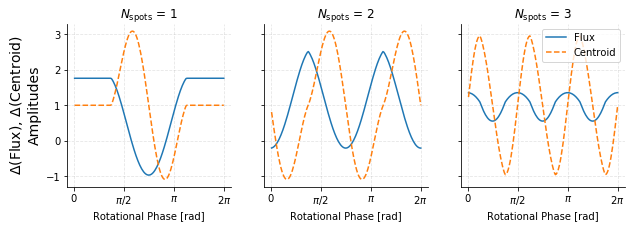

In [6]:
norm_std = lambda x: np.std(x - np.mean(x))

norm = lambda x, nstd: (x - np.mean(x)) / nstd + 1

fig, ax = plt.subplots(1, len(spots), figsize=(10, 3), sharex=True, sharey=True)
for i, spot_list in enumerate(spots): 
    if i == 0: 
        norm_flux_factor = norm_std(photometry[i, :])
        norm_astr_factor = norm_std(astrometry[i, :])
    norm_phot = norm(photometry[i, :], norm_flux_factor)
    norm_astr = norm(astrometry[i, :], norm_astr_factor)
    ax[i].plot(np.cumsum(rotation_angle), norm_phot, label='Flux')
    
    x_ticks = np.linspace(0, 2*np.pi, 4)
    x_tick_labels = ['0', '$\pi/2$', '$\pi$', '$2\pi$']
    
    ax[i].plot(np.cumsum(rotation_angle), norm_astr, ls='--', label='Centroid')
    ax[i].set_title("$N_{{\mathrm{{spots}}}}$ = {0:d}".format(len(spot_list)))
    ax[i].set_xlabel('Rotational Phase [rad]')
    ax[i].set_xticks(x_ticks)
    ax[i].set_xticklabels(x_tick_labels)
    ax[i].grid(ls='--', color='gray', alpha=0.2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
ax[-1].legend()
ax[0].set_ylabel('$\Delta$(Flux), $\Delta$(Centroid)\nAmplitudes', fontsize=14)
fig.savefig('plots/n_spots.pdf', bbox_inches='tight')